# Toy Project - Machine Learning in S&P500 Volitality Estimation

In [14]:
# Import packages and set configuration
import pandas as pd
import numpy as np
from datetime import datetime
from os import listdir
from os.path import isfile, join
from datetime import date
import math
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import seaborn as sns
# Configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

# 0. Abstract

In this project, I work on 30 stocks and the S&P500 intraday data from 2008 to 2017. I generate features from intraday data to estimate the volatility of S&P500 index by implementing 11 machine learning models under a rolling base. Then, I compare the performance of 11 machine learning models in different aspects and achieve 0.365229 mean square error with the best Random Forest model. Finally, I raise several possible applications for this project and discuss aspects that can be improved in future work. The project is organized as follows:

- 1: Data Preparation: Data cleaning, features construction and basic data analysis
- 2: Train models: Train 11 machine learning models under a rolling base, models including:
    - OLS, Ridge, Lasso, Elastic Net, Adaptive Lasso, Adaptive Elastic Net 
    - Linear Boosting, Linear Bagging
    - RandomForest, Deep RandomForest, BoostTree
- 3: Model comparison: Compare 11 machine learning models from different aspects, such as shrinkage power and predict power
- 4: Possible applications regarding this project, including risk measure and Volatility timing strategies
- 5: Improvements that can be worked in the future research

In data file:

 - ticker.txt: txt file store Open, High, Low, Close, Volume minute data for each ticker from 1991 to 2017
 - ticker.csv: csv file store Open, High, Low, Close, Volume minute data for each ticker from 2008 to 2017
 - database.csv: store data after preparation, including all features and target value for training models
 - daily_missing_cache.csv: store daily missing data 
 - hourly_missing_cache.csv: store hourly missing data
 - result_AIC.csv: store information criteria for machine learning models
 - result_prediction.csv: store prediction results for machine learning models
 - result_relevant_parameters.csv: store the number of relevant parameters for machine learning models

# 1. Data Preparation
## 1.1 Define data preparation functions

- Generate features for each ticker:
    - Calculate daily realized variance __(RV)__ using 5-minute log returns
        - For each day t, $RV_t = \sum_{i=2}^{78}{r_{i, t}}^2 =\sum_{i=2}^{78}[log(p_{i, t}) - log(p_{i-1, t}))]^2$
        - $p_{i, t}$ means ith 5-minute close price in day t
    - Calculate the number of daily and hourly missing data
    - Calculate daily volume by summing all minutes volume
    

In [ ]:
# Define the function to calculate daily RV
def calculate_RV(X):
    # If there is data for each day
    if len(X.index) != 0:
        # Set index from 9:30 to 15:59, totally 390 data points
        t = X.index[0].replace(minute=30)
        idx = pd.date_range(t, periods=390, freq="T")
        
        # Fill the missing value use the last day close
        X = X.reindex(idx, method='ffill') 
        price = X.resample('5T').last()
        
        # Calculate rv
        r = np.diff(np.log(price),n=1)
        rv = np.sum(r**2)
        return rv

# Obtain daily missing data and hourly missing data
def missing_calculator(X):
    # Need to count missing data for both daily and hourly
    if len(X.index) != 0:
        t = X.index[0].replace(minute=30)
        idx = pd.date_range(t, periods=390, freq="T")
        
        # Fill the missing value use the last day close
        X = X.reindex(idx)
        null_value = X.isnull()
        daily_null = null_value.sum()
        hourly_null = null_value.resample("1H").sum()
        hourly_null.index = ['9H', '10H', '11H', '12H', '13H', '14H', '15H']
        
        # Stack daily null into the hourly null for convenience
        hourly_null['Daily'] = daily_null
        
        return hourly_null
    
# Calculate RV and Volume for each ticker
def ticker_prepare(ticker):
    # Read data from txt file
    data = pd.read_csv('data\\'+ticker+'.txt', parse_dates=[["Date", "Time"]])
    data.set_index('Date_Time', inplace=True)
    data.index = pd.to_datetime(data.index)
    
    # Select data after 2008
    data = data.loc["2008-01-01":, :]
    
    # Store into the csv file
    data.to_csv('data\\'+ticker+'.csv', index=True)
    
    # Calculate RV and volume
    RV = data.Close.resample('1D').apply(calculate_RV).dropna(axis=0)
    volume = data.Volume.resample('1D').sum()
    
    # Count missing data
    missing = data.Close.resample('1D').apply(missing_calculator).dropna(axis=0)
    missing = missing.unstack(level=1)
    
    # Change column names and concat RV and volume
    RV.rename(ticker+"_RV", inplace=True)
    volume.rename(ticker+"_Volume", inplace=True)
    result = pd.concat([RV, volume], axis=1, join="inner")
    
    return result, missing

## 1.2 Calculate features for tickers

- Filter data from 2008 to 2017
- Run above functions for all tickers to calculate features
- Store daily and hourly missing data for each ticker

In [ ]:
# Get all tickers from names of .txt files
datafiles = [f for f in listdir("data") if isfile(join("data", f))]
tickers =[f[:-4] for f in datafiles if f[-3:] == 'txt']

# Initialize containers
database = pd.DataFrame()
daily_missing_cache = pd.DataFrame()
hourly_missing_cache = pd.DataFrame(columns = ['9H', '10H', '11H', '12H', '13H', '14H', '15H'])

for t in tickers:
    if database.empty:
        database, missing = ticker_prepare(t)
    else:
        result, missing = ticker_prepare(t)
        database = database.join(result, how='left')
        
    # Cache missing data
    hourly_missing = missing.iloc[:, :-1]
    daily_missing = missing.iloc[:, -1]
    hourly_sum = hourly_missing.sum(axis=0)
    
    # Cache for sum hourly missing data and daily missing data for each ticker
    hourly_missing_cache.loc[t, :] = hourly_sum.values
    daily_missing_cache[t] = daily_missing
    print(t, ' is done!')
    
    # Store data into csv file for convenience
    database.to_csv('database.csv', index=True)
    hourly_missing_cache.to_csv('hourly_missing_cache.csv', index=True)
    daily_missing_cache.to_csv('daily_missing_cache.csv', index=True)

## 1.3 Analyze features

### 1.3.0 Cleanning the database

- Drop tickers start after 2008 and S&P500 volume (which suppose to be NaN)

In [4]:
database = pd.read_csv("database.csv", index_col = 0)
database.index = pd.to_datetime(database.index)
drop_tickers = [t for t in database.columns if math.isnan(database[t][0])]
drop_tickers += ['SP500_Volume']  # Drop SP500 volume
database = database.drop(drop_tickers, axis=1) 
database = database.dropna()

### 1.3.1 Plot realized variance (RV) for S&P500 and check the properties

From the plot of time series, we can find:
 - The RV from 2008 to 2017 is not stationary, but the chunk from 2012 to 2015 is relative stationary than other periods
 - The RV experienced several serious shocks and most of them are consistency with events that happened in the financial market, such as:
     * 2008-2009: 2008 financial crisis --- https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
     * The middle of 2010: 2010 Flash Crash --- https://en.wikipedia.org/wiki/2010_Flash_Crash
     * The end of 2011: August 2011 stock markets fall --- https://en.wikipedia.org/wiki/August_2011_stock_markets_fall
     * The end of 2015: 2015-16 stock market selloff --- https://en.wikipedia.org/wiki/2015%E2%80%9316_stock_market_selloff
 - I will not treat these shocks as extreme values, because I think these events contained very important information regarding the market and a good model should try to explain them

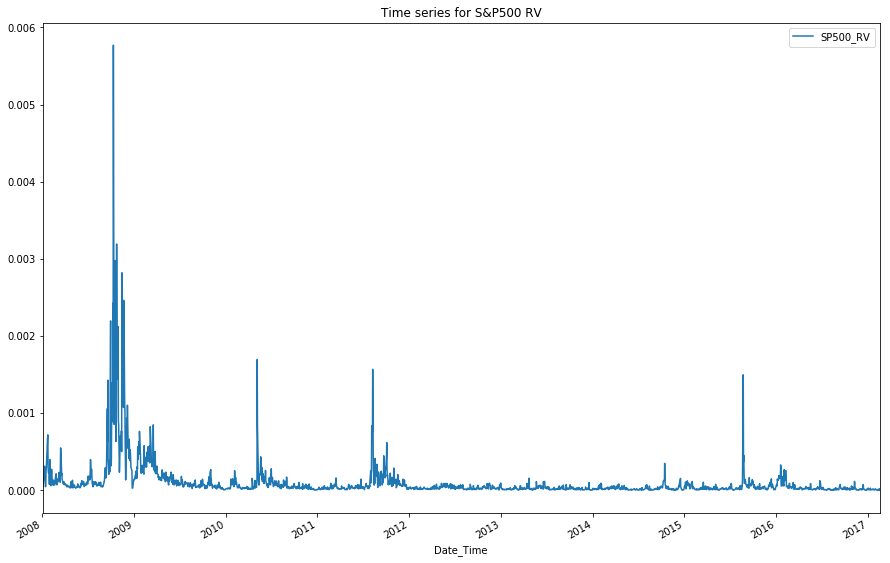

In [5]:
# Plot the time series
database['SP500_RV'].plot(x="time", title = 'Time series for S&P500 RV', legend = True, y="SP500_RV")

## 1.4 Analyze missing values

 ### 1.4.1 Check daily missing values
 
  - By calculating the total missing value, I find there is no much variations among most of the tickers, except the TRV has relative more missing value

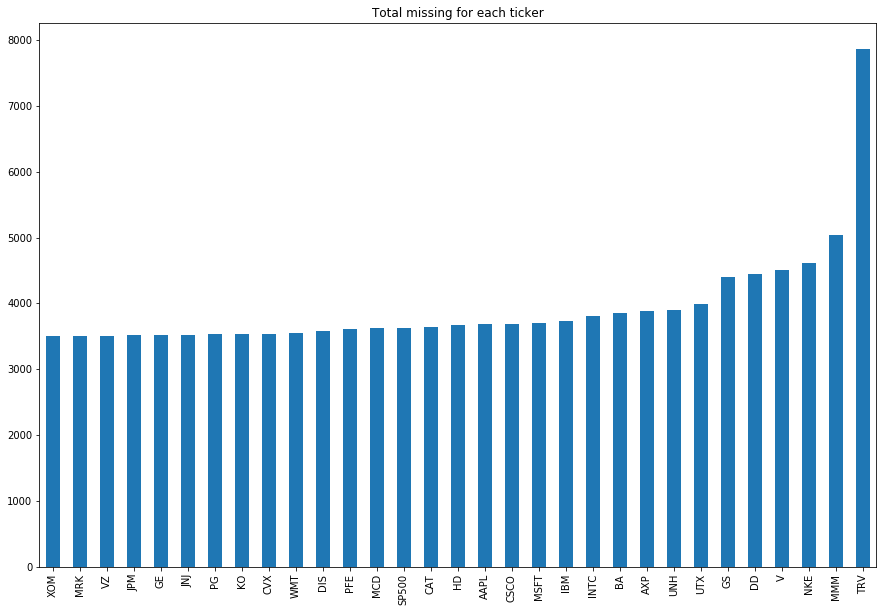

In [6]:
daily_missing = pd.read_csv('daily_missing_cache.csv', index_col=0)
total_missing = daily_missing.sum(axis=0)
total_missing.sort_values().plot('bar', title = 'Total missing for each ticker')

### 1.4.2 Check the hourly missing value

 - I accumulate the hourly number of missing data for each ticker each hour and plot the bar chart
 - It's interesting to find most of the missing value happened in 13:00 - 15:00. Since the missing value may due to no transactions, I guess the trading enthusiasm is not that high in the afternoon than the trading enthusiasm in the morning

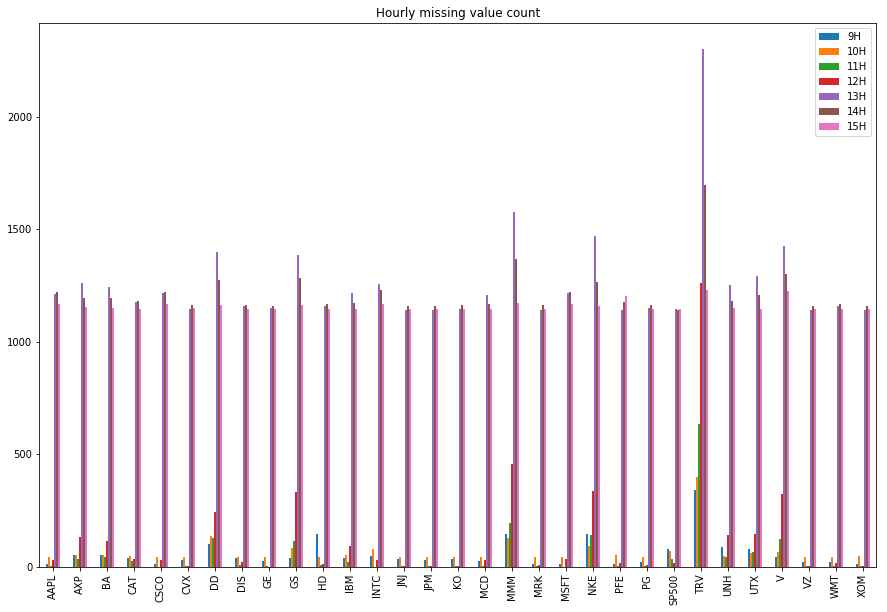

In [7]:
hourly_missing = pd.read_csv('hourly_missing_cache.csv', index_col=0)
hourly_missing.plot(kind = 'bar', title = 'Hourly missing value count')

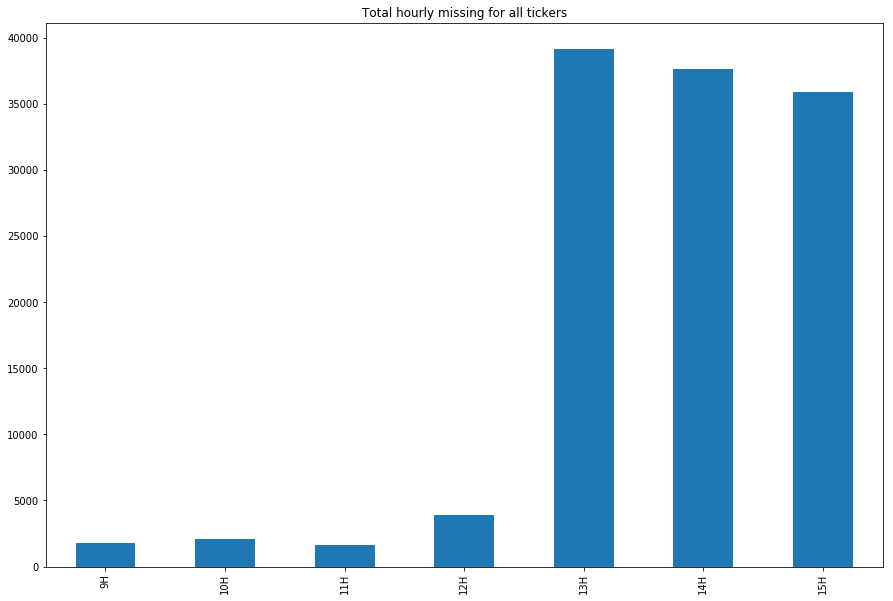

In [8]:
total_hourly_missing = hourly_missing.sum(axis=0)
total_hourly_missing.plot('bar', title="Total hourly missing for all tickers")

## 1.5 Construct database for training machine learning models

 - Add 1 lag values for all features including RVs, Volumes for each ticker
 - Add daily missing value as features and add tiny rand noise to avoid the numerical problem when training models

In [9]:
# Add lag term for the database
database_lag = database.copy().shift(1)
database_lag.columns = [col_name + '_lag1' for col_name in database_lag.columns]
database = pd.concat([database, database_lag], axis=1)

# Arrange missing data
drop_tickers = [t for t in daily_missing.columns if math.isnan(daily_missing[t][0])]
daily_missing = daily_missing.drop(drop_tickers, axis=1)
daily_missing = daily_missing.dropna()
daily_missing.index = pd.to_datetime(daily_missing.index)
daily_missing.columns = [col_name + "_miss" for col_name in daily_missing.columns]

# Since the daily missing value is very sparse, I add some tiny rand values to avoid numierical problems of regression models
rand = np.random.randn(*daily_missing.shape)
daily_missing = daily_missing + rand/100
database = pd.concat([database, daily_missing], axis=1, join='inner')
database['Y_lead'] = np.log(database['SP500_RV']).shift(-1)

# drop the first and the last rows, which contains nan values
database = database.iloc[1:-1, :]

# 2. Train models
## 2.1 Define standarlize function

In [8]:
def standarlize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis= 0)
    X = (X - mean)/std
    return X, mean, std

## 2.2 Define machine learning models for each rolling window

### 2.2.1: OLS regression for each window

 - Calculate AIC for each window
 - Return predict value (1001th S&P500 RV), AIC, and the number of relevant parameters (!=0) of the window for the best model

In [9]:
def OLS_window(X_train, Y_train, X_test):
    T, p = X_train.shape
    
    # Fit regression model
    ols_model = linear_model.LinearRegression(fit_intercept=False)
    ols_model.fit(X_train, Y_train)
    
    # Estimate and predict
    Y_estimate = ols_model.predict(X_train)
    Y_predict = ols_model.predict(X_test)
    
    # Cache relevant variables
    coef = ols_model.coef_[0]
    p_relevant = np.sum(coef != 0)
    
    # Calculate Information Criteria
    df = p-1
    sigma_2 = 1/(T-df) * np.sum((Y_train-Y_estimate)**2)[0]
    AIC = np.log(sigma_2) + df * 2/T
    
    return Y_predict[0][0], p_relevant, AIC

### 2.2.2: Ridge regression for each window

 - Tune the penalty parameter by minimizing AIC 
 - Return predict value (1001th S&P500 RV), AIC, the number of relevant parameters (!=0) of the window for the best model 

In [10]:
def ridge_window(X_train, Y_train, X_test, alphas):
    best_AIC = float('inf')
    T, p = X_train.shape
    p_relevant_best = None
    
    for alpha in alphas:
        # Fit ridge model
        ridge_model = linear_model.Ridge(alpha=alpha, fit_intercept=False)
        ridge_model.fit(X_train, Y_train)
        
        Y_estimate = ridge_model.predict(X_train) # Get estimate y_hat for AIC calculation
        
        # Get the number of relevant parameters
        coef = ridge_model.coef_
        p_relevant = np.sum(coef!=0)
        
        # Calculate Information Criteria
        df = np.trace(np.dot(X_train, np.linalg.inv(np.dot(X_train.T, X_train) + np.eye(p_relevant) * alpha)).dot(X_train.T))
        sigma_2 = 1/(T-df) * np.sum((Y_train-Y_estimate)**2)[0]
        AIC = np.log(sigma_2) + df * 2/T
        
        # Query for the best AIC and cache the information
        if AIC < best_AIC:
            best_AIC = AIC
            best_alpha = alpha
            best_predict = ridge_model.predict(X_test)[0][0]
            p_relevant_best = p_relevant
        
    return best_predict, p_relevant_best, best_AIC

### 2.2.3 Lasso regression for each window

 - __Here I adjust penalty $\alpha = \frac{\alpha_{origin}}{2*T}$ to control the penalty parameters in the same scale with penalty parameters in other shrinkage models, because of the different formulas coded in sklearn.__
 - For lasso model, the degrees of freedom is equal to the number of nonzero coefficients
 - Tune the penalty parameter by minimizing AIC 
 - Return predict value(1001th S&P500 RV), AIC, and the number of relevant parameters (!=0) of the window for the best model

In [11]:
def lasso_window(X_train, Y_train, X_test, alphas):
    T, p = X_train.shape
    alphas_scale = alphas/(2*T)  # Adjust alpha because of the different scale coded in sklearn model
    best_AIC = float('inf')
    
    for alpha in alphas_scale:
        # Fit lasso model
        lasso_model = linear_model.Lasso(alpha=alpha, fit_intercept=False)
        lasso_model.fit(X_train, Y_train)
        
        # Get estimations for AIC calculation
        Y_estimate = lasso_model.predict(X_train)
        Y_estimate.shape = (T, 1)
        
        # Get model coefficients
        coef = lasso_model.coef_

        # Calculate Information Criteria
        df = sum(coef!=0)  # For lasso model, the degress of freedom is equal to the number of nonzero coefficients
        sigma_2 = 1/(T-df) * np.sum((Y_train-Y_estimate)**2)[0]
        AIC = np.log(sigma_2) + df * 2/T
        
        # Query for the best AIC 
        if AIC < best_AIC:
            best_AIC = AIC
            best_alpha = alpha
            best_predict = lasso_model.predict(X_test)[0]
            p_relevant_best = df
    
    return best_predict, p_relevant_best, best_AIC, best_alpha * (2*T)

### 2.2.4 Elastic Net for each window

 - The l1_ratio in sklearn is similar with the mixing parameter $\alpha$ between l1 and l2 norm in our course, and the $\alpha$ in sklearn is similar as the penalty parameter $\lambda$ in our course. Because there is a 0.5 before l2 norm in sklearn, we need to set l1_ration to 1/3 to make sure l1 and l2 have the same penalty
 - __Here I adjust penalty $\alpha = \frac{\alpha_{origin}}{4/3*T}$ to control the penalty parameters in the same scale with penalty parameters in other shrinkage models, because of the different formulas coded in sklearn.__
 - __We need to rescale $\lambda_{2} = \frac{4T\alpha}{3} * 0.5$ to calculate degree of freedom for AIC__
 - Tune the penalty parameter by minimizing AIC 
 - Return predict value(1001th S&P500 RV), AIC, and the number of relevant parameters (!=0) of the window for the best model

In [12]:
def elastic_net_window(X_train, Y_train, X_test, alphas):
    T, p = X_train.shape
    alphas_scale = alphas/(4/3*T)  # Adjust alpha because of the different scale coded in sklearn model
    best_AIC = float('inf')
    
    for alpha in alphas_scale:
        # Fit elastic net model
        elastic_net_model = linear_model.ElasticNet(alpha=alpha, l1_ratio=1/3, fit_intercept=False)
        elastic_net_model.fit(X_train, Y_train)
        
        # Get estimates for AIC calculation
        Y_estimate = elastic_net_model.predict(X_train)
        Y_estimate.shape = (T, 1)
        
        # Get the number of relevant parameters
        coef = elastic_net_model.coef_
        p_relevant = np.sum(coef!=0)
        
        # Calculate Information Criteria
        X_active = X_train.iloc[:, coef!=0]  # Select active set
        lambda2 = 4/3 * T *alpha * 0.5   # Rescale lambda2 
        df = np.trace(np.dot(X_active, np.linalg.inv(np.dot(X_active.T, X_active) + np.eye(p_relevant) * lambda2)).
                      dot(X_active.T))
        sigma_2 = 1/(T-df) * np.sum((Y_train-Y_estimate)**2)[0]
        AIC = np.log(sigma_2) + df * 2/T
        
        # Query for the best AIC 
        if AIC < best_AIC:
            best_AIC = AIC
            best_alpha = alpha
            best_predict = elastic_net_model.predict(X_test)[0]
            p_relevant_best = p_relevant
    
    return best_predict, p_relevant_best, best_AIC, best_alpha * (4/3*T)

### 2.2.5 Adaptive Lasso for each window

 - Run adaptive lasso for each window based on the formula: $argmin\sum_{t=1}^{T}[y_t - \beta'x_t]^{2} + \alpha\sum_{j=1}^{p}w_j|\beta_j|$
 - I run standard lasso first then calcualte weights by: $w_j = \frac{1}{|\beta_j| + \frac{1}{\sqrt{T}}}$, where $\beta_j$ is the coefficient estimated from standard lasso
 - __Because there is no availabe adaptive lasso API in sklearn, I scale the data of each sample by $X_{t, j} = \frac{X_{t, j}}{w_j}$ to achieve same optimize effect__
 - In adaptive lasso model, I still need to adjust penalty $\alpha = \frac{\alpha_{origin}}{2*T}$ to control the penalty parameters in the same scale with penalty parameters in other shrinkage models, because of the different formulas coded in sklearn.
 - Tune the penalty parameter by minimizing AIC 
 - Return predict value(1001th S&P500 RV), AIC, and the number of relevant parameters (!=0) of the window for the best model 

In [13]:
def adaptive_lasso_window(X_train, Y_train, X_test, alphas):
    T, p = X_train.shape
    alphas_scale = alphas/(2*T)  # Rescale alpha
    best_AIC = float('inf')
    
    for alpha in alphas_scale:
        # Fit prior lasso model
        lasso_model = linear_model.Lasso(alpha=alpha, fit_intercept=False)
        lasso_model.fit(X_train, Y_train)
        
        # Calculate weight for adaptive lasso
        coef = lasso_model.coef_
        weight = 1/(np.abs(coef) + 1/np.sqrt(T))
        weight.shape = (p, 1)
        
        # Adjust the X_train and X_test by weight for sklearn API
        X_train_adaptive = X_train.copy()/weight.T
        X_test_adaptive = X_test.copy()/weight.T
        
        # Fit the adaptive lasso model
        lasso_model.fit(X_train_adaptive, Y_train)
        coef_adaptive = lasso_model.coef_  # The real coef = coef/weight
        
        # Estimate Y for AIC calculation
        Y_estimate = lasso_model.predict(X_train_adaptive)
        Y_estimate.shape = (T, 1)
        
        # Calculate Information Criteria
        X_active = X_train.iloc[:, coef_adaptive!=0]
        df = np.trace(np.dot(X_active, np.linalg.inv(np.dot(X_active.T, X_active))).dot(X_active.T))
        sigma_2 = 1/(T-df) * np.sum((Y_train-Y_estimate)**2)[0]
        AIC = np.log(sigma_2) + df * 2/T
        
        # Query for the best AIC 
        if AIC < best_AIC:
            best_AIC = AIC
            best_alpha = alpha
            best_predict = lasso_model.predict(X_test_adaptive)[0]
            p_relevant_best = np.sum(coef_adaptive != 0)
        
    return best_predict, p_relevant_best, best_AIC, best_alpha * (2*T)

### 2.2.6 Adaptive Elastic net for each window

 - Run adaptive elastic net for each window based on the formula: $argmin\sum_{t=1}^{T}[y_t - \beta'x_t]^{2} + \lambda\alpha\sum_{i=1}^{p}w_i^2 + (1-\alpha)\lambda\sum_{j=1}^{p}w_j|\beta_j|$
 - I set mixing parameter $\alpha=0.5$ and run standard elastic net first
 - Based on the coeffcient $\beta_j$ from standard elastic net, I calcualte weights by: $w_j = \frac{1}{|\beta_j| + \frac{1}{\sqrt{T}}}$
 - __Because there is no availabe adaptive elastic net API in sklearn, I first implement data augmentation (refered from Lecture 2 page 8) and run adpative lasso similar with function adaptive_lasso_window to achieve same optimize effect__
 - In adapative lasso model, I still need to adjust penalty $\alpha = \frac{\alpha_{origin}}{2*T}$ to control the penalty parameters in the same scale with penalty parameters in other shrinkage models, because of the different formulas coded in sklearn.
 - Tune the penalty parameter by minimizing AIC 
 - Return predict value(1001th S&P500 RV), AIC, and the number of relevant parameters (!=0) of the window for the best model

In [9]:
def adaptive_elastic_net_window(X_train, Y_train, X_test, alphas):
    T, p = X_train.shape
    best_AIC = float('inf')
    
    for alpha in alphas:
        # Fit prior elastic net model 
        elastic_net_model = linear_model.ElasticNet(alpha=alpha/(4/3*T), l1_ratio=1/3, fit_intercept=False)
        elastic_net_model.fit(X_train, Y_train)
        
        # Calculate adaptive weight
        coef = elastic_net_model.coef_
        weight = 1/(np.abs(coef) + 1/np.sqrt(T))
        weight.shape = (p, 1)
        
        # Do matrix augment to mimic optimization process for the adapative elastic net
        augment_matrix = np.eye(p) * np.sqrt(alpha * 0.5)
        X_train_aug = np.concatenate((X_train.values, augment_matrix), axis=0)
        Y_train_aug = np.concatenate((Y_train.values, np.zeros((p, 1))), axis=0)
        
        # Fit the adaptive lasso model using augmented data matrix to mimic adaptive elastic net
        X_train_adaptive = X_train_aug.copy()/weight.T
        X_test_adaptive = X_test.copy()/weight.T
        lasso_model = linear_model.Lasso(alpha=alpha/(2*T), fit_intercept=False)
        lasso_model.fit(X_train_adaptive, Y_train_aug)
        
        # Estimation for AIC calculation
        Y_estimate = lasso_model.predict(X_train_adaptive[:T, :])
        Y_estimate.shape = (T, 1)
        
        # Get the number of relevant coefficients
        coef_adapative = lasso_model.coef_  # Cache coefficent
        p_active = np.sum(coef!=0)
        
        # Calculate Information Criteria
        X_active = X_train.iloc[:, coef!=0]
        df = np.trace(np.dot(X_active, np.linalg.inv(np.dot(X_active.T, X_active) + 0.5 * alpha * np.eye(p_active))).dot(X_active.T))
        sigma_2 = 1/(T-df) * np.sum((Y_train-Y_estimate)**2)[0]
        AIC = np.log(sigma_2) + df * 2/T
        
        # Query for the best AIC 
        if AIC < best_AIC:
            best_AIC = AIC
            best_alpha = alpha
            best_predict = lasso_model.predict(X_test_adaptive)[0]
            p_relevant_best = np.sum(coef_adapative!=0)
       
    return best_predict, p_relevant_best, best_AIC

### 2.2.7 Linear Boosting Implementation

- Every iteration I fit a univariate OLS to the residual as the simple learner, then I stack all simpler OLS learners together as the gradient boosting model
- I select the best model by using AIC
- Return predict value (1001th S&P500 RV), AIC, and the number of relevant parameters (!=0) of the window for the best model 

In [15]:
# Define simple learners for each features 
def simple_learners(X, U, LR):
    X = X.values.reshape((X.shape[0], 1))
    reg = LR.fit(X, U)
    MSE = np.sum((U - reg.predict(X))**2)
    return pd.Series([reg.coef_[0][0], MSE.values[0]], index=["beta", "MSE"])

# Implememnt linear boosting for each window
def linear_boosting_window(X_train, Y_train, X_test, v=0.2, minIt=100, maxIt=200, ic_break=True):
    T, p = X_train.shape
    
    # Create containers
    Y_hat = pd.Series(Y_train.mean()[0], index=Y_train.index)
    U = pd.DataFrame(None, index=Y_train.index, columns=['U'])
    Betas = pd.Series(0.0, index=X_train.columns, )  # Cache the information regarding betas
    Cache_beta = pd.DataFrame(columns = X_train.columns)
    Cache_AIC = []
    S = np.ones((T, T))/T
    best_AIC = float('inf')
    best_iter = None
    df_final = float('nan')
    
    # Set regression model
    LR = linear_model.LinearRegression(fit_intercept=False)
    
    for i in range(maxIt):
        U['U'] = Y_train['Y_lead'] - Y_hat
        # Apply for each column - feature to train simple learners
        result = X_train.apply(simple_learners, axis=0, args = (U, LR))
        # Cache the information regarding the best learner
        best_learner = result.loc['MSE', :].idxmin()
        Betas[best_learner] += v*result.loc['beta', best_learner]
        Y_hat += v * result.loc['beta', best_learner] * X_train[best_learner]
        
        # Calculate IC
        feature = X_train.loc[:, best_learner].values.reshape((T, 1))
        # Smooth matrix 
        S += v*(feature * 1/(feature.T.dot(feature)[0][0])).dot(feature.T).dot(np.identity(T)-S)
        df = np.trace(S)
        AIC = np.log(1/(T-df)*np.sum((Y['Y_lead'] - Y_hat)**2)) + df*2/T
        
        # Cache information
        Cache_beta.loc[i, :] = Betas.copy()
        Cache_AIC.append(AIC)
        
        # Filter for the best AIC
        if AIC < best_AIC:
            best_AIC = AIC
            best_iter = i
        
        # Set prestop
        if ic_break:
            if i >= minIt and np.min(Cache_AIC[:(i//2)] < AIC):
                break
    
    best_coef = Cache_beta.loc[best_iter, :].values.reshape((1, p))
    best_coef[0, -1] += Y_train.mean()[0]
    Y_estimate = X_test.values.dot(best_coef.T)
    p_relevant = np.sum(best_coef[0] != 0.0)
    
    return Y_estimate[0][0], p_relevant, best_AIC

### 2.2.8 Linear Bagging Implementation

 - Since we are dealing with time series data, I use block bootstrap (introduced by Künsch (1989)) to train the bagging model
 - Check the definition of moving block bootstrap: https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Time_series:_Moving_block_bootstrap
 - I fit a simple OLS model to each bootstrap model, then calculate the mean of all coefficients for prediction
 - Return predict value(1001th S&P500 RV) and the number of relevant parameters (!=0) of the window for the best model 

In [16]:
def linear_bagging_window(X_train, Y_train, X_test, B=100, Lblock=250, m=4, t_stat=1.96):
    data_set = pd.concat([X_train, Y_train], axis=1, join="inner")
    data_set = data_set.astype('float') # Set datatype for ols package
    # Use the first index of each block as the key to query blocks
    block_index = range(X_train.shape[0] - Lblock + 1)
    EBetas = pd.DataFrame(0, columns=X_train.columns, index=['beta']) # Expected betas
    
    for b in range(B):
        bootstrap_samples = pd.DataFrame(columns=data_set.columns)
        for i in range(m):
            i = random.choice(block_index)
            bootstrap_samples = bootstrap_samples.append(data_set.iloc[i:i+Lblock, :].copy())
        
        boot_X_train, boot_Y_train = bootstrap_samples.iloc[:, :-1], bootstrap_samples.iloc[:, -1:]
        # Train model
        model = sm.OLS(boot_Y_train['Y_lead'].values, boot_X_train.values).fit()
        beta = model.params
        # Set insignificant parameters to 0
        # beta[np.absolute(model.tvalues) > t_stat] = 0  ## That's wired
        EBetas += beta
        
    EBetas /= B
    Y_estimate = X_test.dot(EBetas.T)
    p_relevant = np.sum(EBetas.values[0] != 0.0)
    return Y_estimate.values[0][0], p_relevant

### 2.2.9 Random Forests implementation for each window

- Train Random Forest model for each window using max_depth = 3 and n_estimators = 200
- Here we set max_depth equal to 3 to compare with the boosted trees
- Return predict value(1001th S&P500 RV) of the window

In [17]:
def RandomForest_window(X_train, Y_train, X_test):
    regr = RandomForestRegressor(max_depth=3, n_estimators=200)
    regr.fit(X_train, Y_train['Y_lead'])
    Y_estimate = regr.predict(X_test)
    return Y_estimate[0]

### 2.2.10 Random Forests implementation without max_depth for each window
- Train Random Forest model for each window without setting max_depth to check the robustness of the random forest model
- Return predict value(1001th S&P500 RV) of the window

In [18]:
def RandomForest_deep_window(X_train, Y_train, X_test):
    regr = RandomForestRegressor(max_depth=None, n_estimators=200)
    regr.fit(X_train, Y_train['Y_lead'])
    Y_estimate = regr.predict(X_test)
    return Y_estimate[0]

### 2.2.11 Boosted trees for each window

- I do not use validation for convenience, because the data is time series and the cross-validation in the package is not implemented as hv-cross-validation and gradient boosting is fairly robust to over-fitting

In [19]:
def BoostTree_window(X_train, Y_train, X_test):
    regr = GradientBoostingRegressor(loss='ls', learning_rate=0.2, n_estimators=200, max_depth=3, validation_fraction=0)
    regr.fit(X_train, Y_train['Y_lead'])
    Y_estimate = regr.predict(X_test)
    return Y_estimate[0]

## 2.3 Train the models

 - Train all models under the rolling base and the length of rolling window set to be 1000 days
 - Cache prediction series for all models
 - Cache the number of relevant parameters for models: OLS, Ridge, Lasso, Elastic Net, Adaptive Lasso, Adaptive elastic net, Linear Boost, Linear Bagging
 - Cache the AIC of best models for OLS, Ridge, Lasso, Elastic Net, Adaptive Lasso, Adaptive elastic net, Linear Boost

In [ ]:
n = database.shape[0]

# Create Dataframe to store the results
model_names = ['ols', 'ridge', 'lasso', 'enet', 'adapt_lasso', 'adapt_enet', 'linear_boost', 'linear_bagging', 
               'RandomForest', 'RandomForest_deep', 'BoostTree']
result_prediction = pd.DataFrame(columns= ['predict_'+ name for name in model_names] + ['Y_test'])
result_relevant_param = pd.DataFrame(columns=['rel_param_'+ name for name in model_names if name not in 
                                     ['RandomForest', 'RandomForest_deep', 'BoostTree']])
result_AIC = pd.DataFrame(columns=['AIC_'+ name for name in model_names if name not in 
                                   ['linear_bagging', 'RandomForest', 'RandomForest_deep', 'BoostTree']])

# Set the range of penalty parameters
# alphas = np.array([10**(x) for x in range(-5, 1)] + [2, 2.5, 3, 3.5])
alphas = np.linspace(0.001, 10, 50)
# Rolling the whole dataset
for i in range(n-999):
    train_window = database.iloc[i:1000+i, :].copy()
    
    # standardize training data and add constant
    X, Y = train_window.iloc[:, :-1], train_window.iloc[:, -1:]
    X_train, Y_train = X.iloc[:-1, :], Y.iloc[:-1, :]
    X_test, Y_test = X.iloc[-1:, :], Y.iloc[-1:, :].values[0][0]
    X_train, mean, std = standarlize(X_train)
    X_train['constant'] = 1  # Add constant parameters for X_train
    
    # Standarlize and add constant for X_test
    X_test = (X_test-mean)/std
    X_test['constant'] = 1
    
    # Call pre-defined training functions for different models
    predict_ols, p_rel_ols, AIC_ols = OLS_window(X_train, Y_train, X_test)
    predict_ridge, p_rel_ridge, AIC_ridge = ridge_window(X_train, Y_train, X_test, alphas)
    predict_lasso, p_rel_lasso, AIC_lasso = lasso_window(X_train, Y_train, X_test, alphas)
    predict_enet, p_rel_enet, AIC_enet = elastic_net_window(X_train, Y_train, X_test, alphas)
    predict_alasso, p_rel_alasso, AIC_alasso = adaptive_lasso_window(X_train, Y_train, X_test, alphas)
    predict_aenet, p_rel_aenet, AIC_aenet = adaptive_elastic_net_window(X_train, Y_train, X_test, alphas)
    predict_linearboost, p_rel_linearboost, AIC_linearboost = linear_boosting_window(X_train, Y_train, X_test)
    predict_linearbagging, p_rel_linearbagging = linear_bagging_window(X_train, Y_train, X_test)
    predict_RandomForest = RandomForest_window(X_train, Y_train, X_test)
    predict_RandomForest_deep = RandomForest_deep_window(X_train, Y_train, X_test)
    predict_BoostTree = BoostTree_window(X_train, Y_train, X_test)

    # Stack results into the dataframe
    time = Y_train.index[-1]
    result_prediction.loc[time, :] = [predict_ols, predict_ridge, predict_lasso, predict_enet, predict_alasso, predict_aenet,
                                        predict_linearboost, predict_linearbagging, predict_RandomForest, 
                                        predict_RandomForest_deep, predict_BoostTree, Y_test]
    result_relevant_param.loc[time, :] = [p_rel_ols, p_rel_ridge, p_rel_lasso, p_rel_enet, p_rel_alasso, p_rel_aenet, 
                                        p_rel_linearboost, p_rel_linearbagging]
    result_AIC.loc[time, :] = [AIC_ols, AIC_ridge, AIC_lasso, AIC_enet, AIC_alasso, AIC_aenet, AIC_linearboost]
    print(time, ': ', i, 'th done')
    
    # Store data into a csv file for convenience
    result_prediction.to_csv('result_prediction.csv')
    result_relevant_param.to_csv('result_relevant_param.csv')
    result_AIC.to_csv('result_AIC.csv')

## 3. Model comparation

### 3.0 Load results

In [61]:
predictions = pd.read_csv('result_prediction.csv', index_col=0)
relevant_param = pd.read_csv('result_relevant_param.csv', index_col=0)
AIC = pd.read_csv('result_AIC.csv', index_col=0)

## 3.1 Calculate mean squared error and compare the performance of all models

- Based on the predict mean square error(MSE of all models, we rank the model performance: Deep Random Forest > Random Forest > Boosting Tree > Adaptive Lasso > Boosting Linear Model > Bagging Linear Model > Lasso > Adaptive Elastic Net > Elastic Net > Ridge Model > OLS
- Based on the predict MSE, all other models beat Benchmark model OLS regression
- Overall, tree models achieved better performance than linear models
- Random Forest model show robustness with the maximum depth
- Adaptive Lasso achieved the best performance among regression models

In [11]:
def calculate_mse(model_names, result):
    n, _ = result.shape
    # Get estimation part
    estimations = result.loc[:, ['predict_'+ name for name in model_names]]
    # Calculate MSE
    Y_test = result.loc[:, 'Y_test'].values
    Y_test.shape = (n, 1)
    estimations = (estimations - Y_test)**2
    MSE = estimations.sum(axis=0)/n
    MSE.index = model_names
    # Print MSE
    return MSE

model_names = ['ols', 'ridge', 'lasso', 'enet', 'adapt_lasso', 'adapt_enet', 'linear_boost', 'linear_bagging', 
               'RandomForest', 'RandomForest_deep', 'BoostTree']
# Calculate and print the MSE for all models
print("MSE for different model: ")
MSE = calculate_mse(model_names, predictions)
print(MSE.sort_values())

MSE for different model: 
RandomForest_deep    0.365229
RandomForest         0.376784
BoostTree            0.431088
adapt_lasso          0.553663
linear_boost         0.560580
linear_bagging       0.603800
lasso                0.636287
adapt_enet           0.645316
enet                 0.654358
ridge                0.678417
ols                  1.898602
dtype: float64


### 3.2 Diebold-Mariano test

- Based on the heatmap of p-values, we can find the Diebold-Mariano test fail to reject the forecasts are statistically different between most of shrinkage regression models and boost tree models
- In general, the predictions from the OLS model and Random Forest model are significantly different from predictions from other shrinkage models

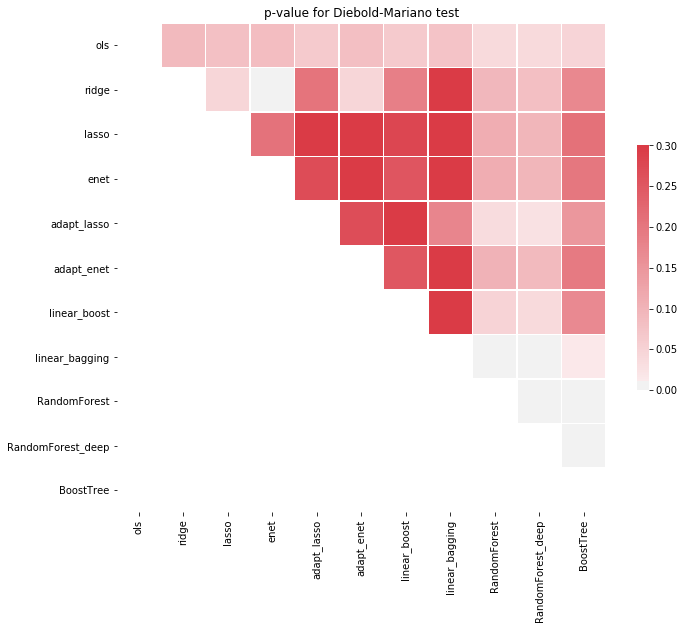

In [29]:
from dm_test import dm_test

model_names = ['ols', 'ridge', 'lasso', 'enet', 'adapt_lasso', 'adapt_enet', 'linear_boost', 'linear_bagging', 
               'RandomForest', 'RandomForest_deep', 'BoostTree']

dm_p_value = pd.DataFrame(0, index=model_names, columns=model_names)

l = len(model_names)
for i in range(l):
    for j in range(i+1, l):
        name1, name2 = model_names[i], model_names[j]
        real = predictions.loc[:, ['Y_test']].values.T[0]
        p1 = list(predictions.loc[:, ['predict_'+ name1]].values.T[0])
        p2 = list(predictions.loc[:, ['predict_'+ name2]].values.T[0])
        rt = dm_test(real, p1, p2, crit="MSE")
        dm_p_value.loc[name1, name2] = rt[1]

# Ploting heat map for dm_p_value
# Generate a mask for the upper triangle
mask = np.zeros_like(dm_p_value, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask = ~mask
for i in range(l):
    mask[i, i] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax.set_title("p-value for Diebold-Mariano test")
sns.heatmap(dm_p_value, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### 3.3 The number of the relevant parameters
 - I calculate the mean of the number of relevant parameters for different models, and rank the models based on shrinkage effect: Adaptive Lasso > Boosting Linear Model > Lasso > Elastic Net > Adaptive Elastic Net > Bagging Linear Model = Ridge Model = OLS;
 - Lasso models and linear boost have better shrinkage effect than other models. OLS, Ridge and Bagging Linear models do not shrink for parameters. Above results are consistent with theories 
 - In general, models with better shrink effect achieved better out-of-sample predict power (based on MSE), apart from bagging model. This observation is consistent with the bias-variance trade-off

The average number of relevant variables for different models:
rel_param_adapt_lasso        40.570766
rel_param_linear_boost       47.470998
rel_param_lasso              82.270688
rel_param_enet              101.674401
rel_param_adapt_enet        103.498840
rel_param_ols               149.000000
rel_param_ridge             149.000000
rel_param_linear_bagging    149.000000
dtype: float64


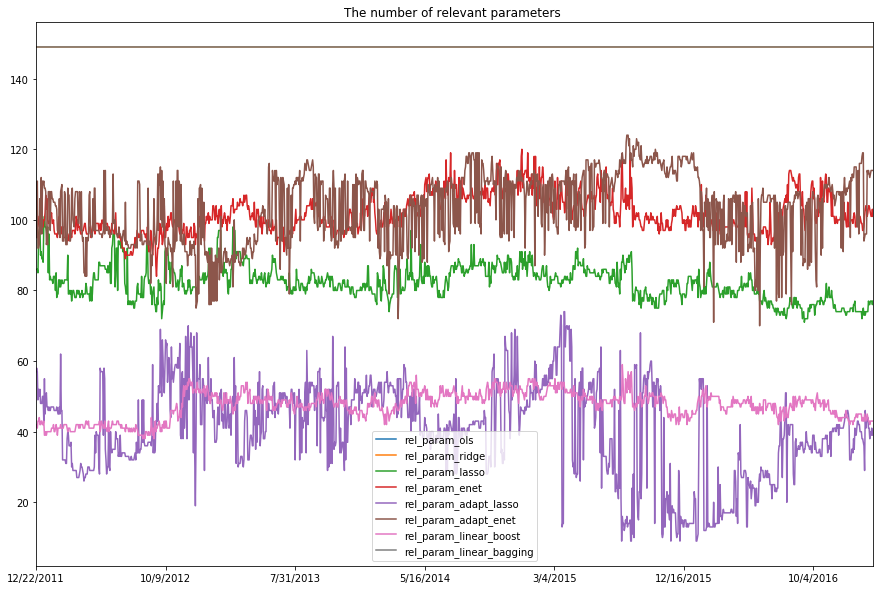

In [13]:
relevant_param.plot(title='The number of relevant parameters ', legend=True)
rel_mean = relevant_param.mean(axis=0)
print('The average number of relevant variables for different models:')
print(rel_mean.sort_values())

### 3.4 The AIC of different models
 - I count the wins for each model based on the AIC and plot the AIC series for each model
 - From the count and plot, we can find better shrinkage power also consistent with better AICs in general, although there exist some exceptions, such as the AICs of linear boost model are lower than AICs of the adaptive lasso, but adaptive lasso has better shrinkage power. This observation shows the linear boost model achieved smaller in-sample error

Winning records: 
linear_boost  win  1293  times


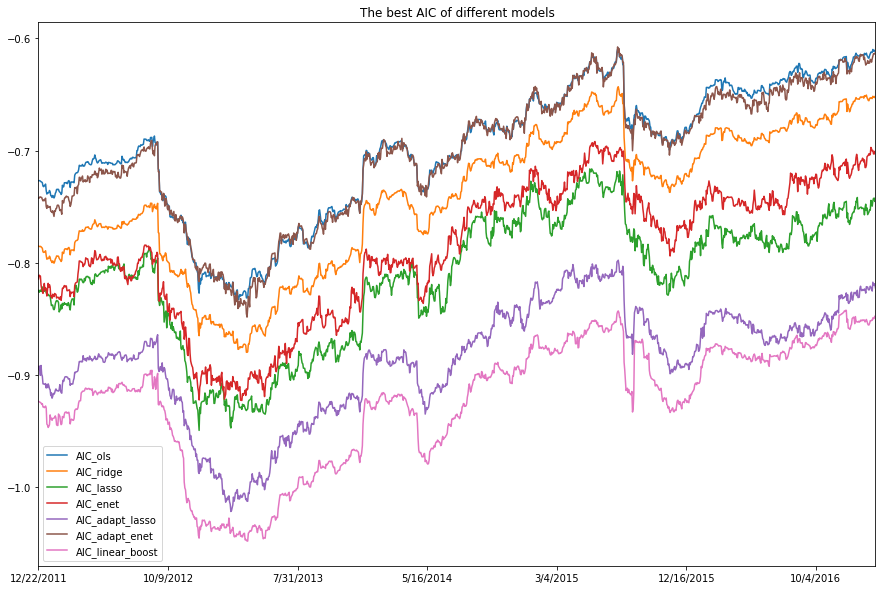

In [30]:
from collections import Counter
# Select the AIC for each models
model_names = ['ols', 'ridge', 'lasso', 'enet', 'adapt_lasso', 'adapt_enet', 'linear_boost', 'linear_bagging', 
               'RandomForest', 'RandomForest_deep', 'BoostTree']

# Count the wins for each model
index_best_model = [np.argmin(AIC.loc[time, :].values) for time in AIC.index]
count = Counter(index_best_model)

# Print
print('Winning records: ')
for i in count:
    print(model_names[i], ' win ', count[i], ' times')

AIC.plot(title='The best AIC of different models')

# 4. Applications

## 4.1 VaR Prediction

 -  One of the main goals to have a good volatility forecast is to compute Value-at-Risk measures
 -  Assume: 
     - the daily returns of the S&P500 are distributed as:  $r_t|(past) = h_t \times \epsilon_t$ and $\epsilon_t$~ N(0, 1)
     - $h_t$ is the conditional standard deviation. Also, suppose that $\sqrt{RV_t}$ is a reasonable approximation to $h_t$
 - Generate predict daily 5% VaR for S&P500 based on predictions of machine models: ${VaR}_{5\%, t+1}= \alpha_{5\%} \times \sqrt{\hat{{RV}_{t+1}}}$
 - Count the total failure of VaR for each model, Where failure of VaR defined as daily return < -VaR
 - Based on the results, we can find models' risk measure performance: Random Forest > Linear Bagging > Deep Random Forest > Elastic Net > Lasso > Adaptive Lasso > Boosting Tree > Ridge Model > Adaptive Elastic Net > Linear Boosting >  OLS
 - Although the risk measure power is not consistent with previous predict power, Random Forest model still achieve the best performance
 - The inconsistency may result from the simple assumption of VaR calculation, we can do more complicated risk measure in further research

RandomForest         105
linear_bagging       106
RandomForest_deep    106
enet                 107
lasso                108
adapt_lasso          108
BoostTree            109
ridge                110
adapt_enet           112
linear_boost         112
ols                  117
Name: Excessed, dtype: int64


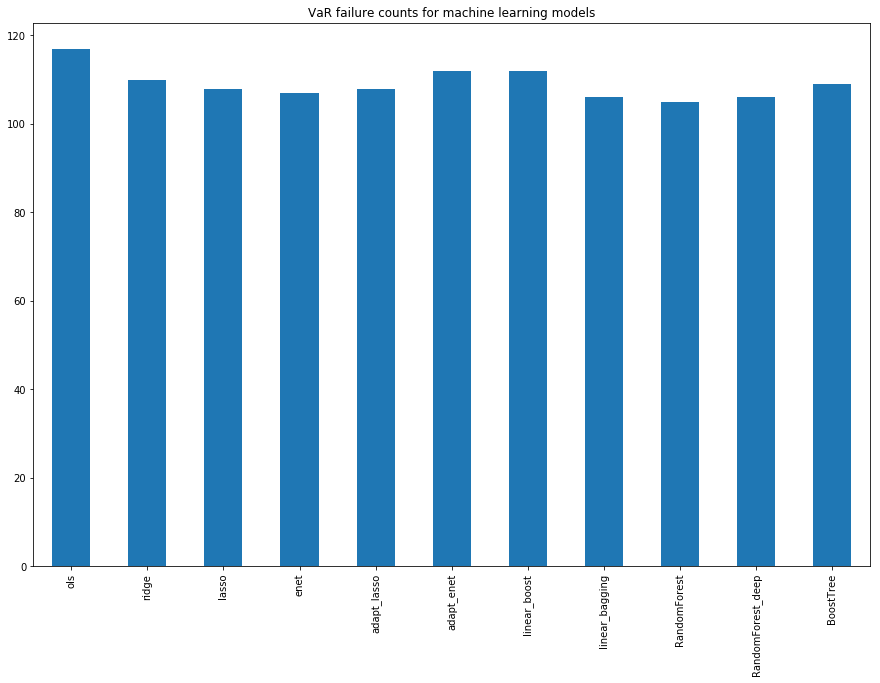

In [106]:
# Construct SP500
SP500 = pd.read_csv('data\\SP500.csv', index_col=0)
SP500.index = pd.to_datetime(SP500.index)
SP500_close = SP500.loc['2011-12-22':, 'Close']
SP500_close = SP500_close.fillna('ffill')
SP500_daily_close = SP500_close.resample('1D').last()
SP500_daily_close = SP500_daily_close.dropna()
SP500_daily_return = SP500_daily_close/SP500_daily_close.shift(1) - 1
SP500_daily_return = SP500_daily_return.shift(-1)[1:-1]
SP500_daily_return.name = "SP500_daily_return"

# Calculate VaR based on normality assumption
predictions.index = pd.to_datetime(predictions.index)
VaR = np.sqrt(np.exp(predictions.iloc[:, :-1]))*1.96
VaR.columns = model_names
cache = pd.concat([-VaR, SP500_daily_return], axis=1, join='inner')

# Count how many times VaR fail, i.e daily return < -VaR 
var_fail_counts = pd.Series(0, index=model_names, name="Excessed")
for name in model_names:
    var_fail_count = cache['SP500_daily_return'] < cache[name]
    var_fail_counts[name] = sum(var_fail_count)
    
print(var_fail_counts.sort_values())
var_fail_counts.plot('bar', title="VaR failure counts for machine learning models")

## 4.2 Volatility timing strategy

- Since we using machine learning algorithms to predict the realized volatility of SP500, I figured out 2 volatility timing strategy: __trade as a mean-variance style and directly trade on volitality__

### 4.2.1 Trade on S&P500 

- This strategy is referred from __Volatility-Managed Portfolios, Alan Moreira__ https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2659431
- This strategy cuts exposure to the risky portfolio when volatility is relatively high and raises exposure to the risky portfolio when the volatility of recent returns is relatively low
- We can directly trade on S&P500 index (ETF product) with the exposure that weighted by the inverse of predicted realized variance to achieve better risk-adjusted return (Sharpe ratio)
- We can trade on ETFs which are tracked S&P500 index, such as:
 - SPDR S&P500 ETF: https://finance.yahoo.com/quote/SPY/
 - iShares Core S&P 500 ETF: https://finance.yahoo.com/quote/IVV?p=IVV&.tsrc=fin-srch
- We can map the inverse of predicted realized variance to a space between 0 and 1 using a squashing function such as tanh to be the exposure:
  - $\hat{exposure_t} = tanh(\frac{1}{\hat{RV_t}^{2}})$, where $\hat{RV_t}$ is predicted value from the machine learning model trained by the previous 1000 size rolling window
- Every day, we can use the previous 1000 size rolling window to train the model and calculate the exposure based on predicted RV, then rebalance the ETF based on the calculated exposure
- We only predict the daily volatility in our HW and rebalance the weight could cost big trading cost. 
- we can build models on different periods (daily, weekly or monthly) using similar logic and backtest their performances, then select the trading period based on the best cost-adjusted performance
- As suggested by the reference, we can extend the strategy by building the model using factors and mean-variance framework, then using the machine learning logical to predict the RV for specific portfolio instead of SP500, and trade on the portfolio based on the same exposure calculated by the inverse of predicted RV

### 4.2.2 Trade on VIX

 - Since we are predicting realized volatility of S&P500, we can directly trade on the volatility
 - We can trade on the VIX Futures or related ETPs, such as:
     - VIX Weeklys Futures: http://cfe.cboe.com/cfe-products/vx-cboe-volatility-index-vix-futures
     - ProShares Ultra VIX Short-Term Futures ETF: https://finance.yahoo.com/quote/UVXY?p=UVXY&.tsrc=fin-srch
     - VelocityShares Daily 2x VIX Short-Term ETN: https://finance.yahoo.com/quote/TVIX?p=TVIX&.tsrc=fin-srch
 - We can trade based on the difference between the predicted volatility in time t+1 and the actual volatility in time t. If the model estimates the volatility will increase, we should long it. On the other hand, we the short it
     - $\hat{exposure_t} = tanh(\hat{RV_t} - RV_{t-1})$, where $\hat{RV_t}$ is predicted value from the machine learning model trained by previous 1000 size rolling window
 - If we trade on Futures, we need to take care of the expiration date (Wednesdays for weekly VIX), we could choose to roll over to the next contract x trading-days before the expiration date. For example, assume x == 1 and the expiration date is every Wednesdays, we start to trade on the next contract on every Tuesday. We can decide x by backtesting and pick the x with the best performance
 - If we trade on ETPs, we may need to using Option to short it, which may bring in more costs. We could backtest to select the best strategy

# 5 Improvements in future research

 - In this project, I only use intraday data of 30 tickers. In future research, I can add more features from different data sources, such as macros data or fix income data to achieve better performance
 - In this project, I only trained 11 basic machine learning models. In future research, I can use more sophisticated models such as Hidden Markov or Neural network
 - I did not tune many hyperparameters for convenience in this project, which could be improved in future research by implement algorithms such as grid search
 - I can backtest the related volatility timing strategies and check their performance in future research 